# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Performing PCA with an Undercomplete Linear Autoencoder

In [7]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

In [7]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [9]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 11ms/step


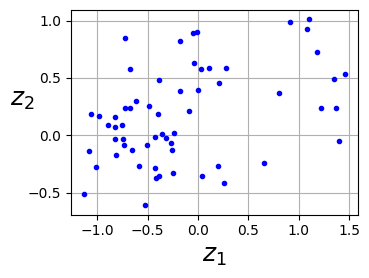

In [10]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using Keras

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
tf.random.set_seed(42)

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 5ms/step - loss: 0.0252 - val_loss: 0.0216
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0182 - val_loss: 0.0176
Epoch 3/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0155 - val_loss: 0.0153
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 7/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 8/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 9/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 10/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.01

## Visualizing the Reconstructions

1/1 [==============================] - 0s 185ms/step


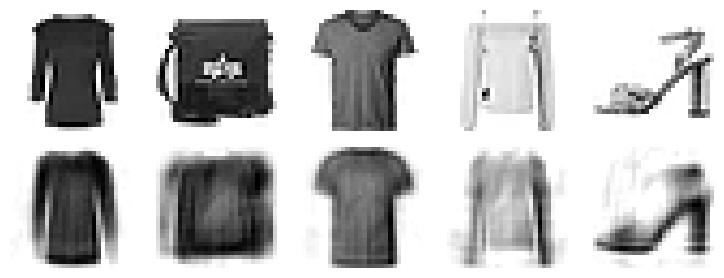

In [10]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    
plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")
plt.show()

## Visualizing the Fashion MNIST Dataset

In [22]:
from sklearn.manifold  import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


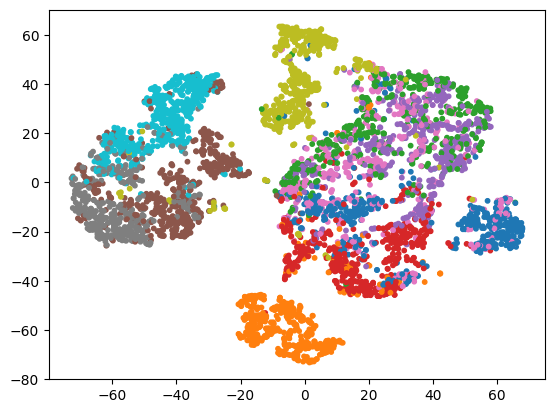

In [23]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

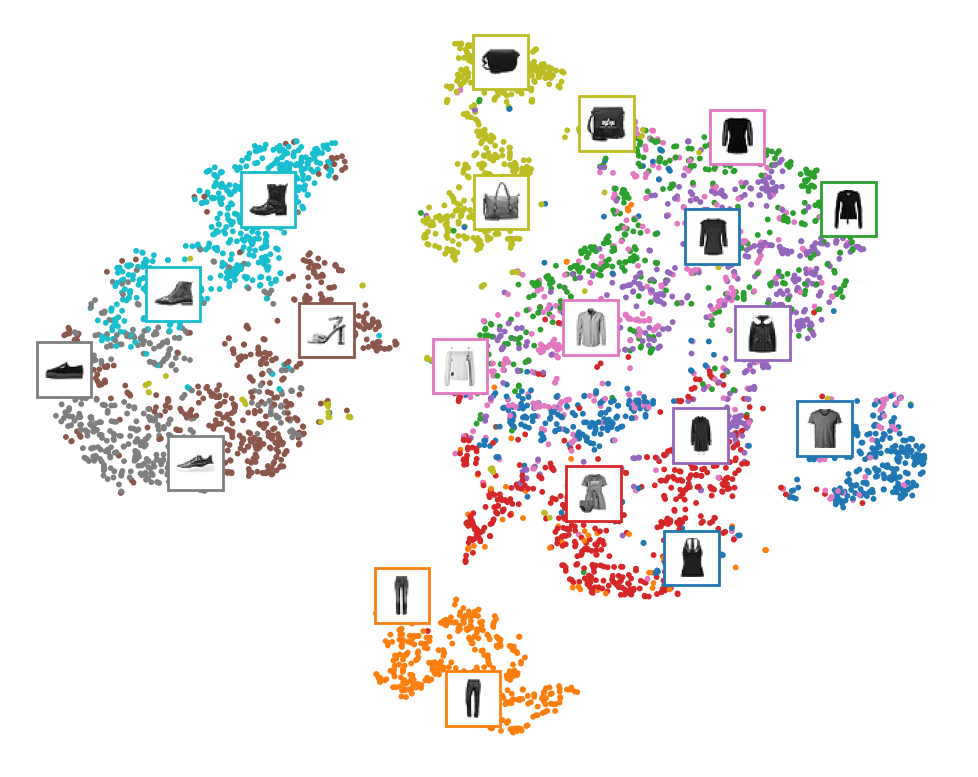

In [24]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops = {"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Unsupervised Pretraining using Autoencoders

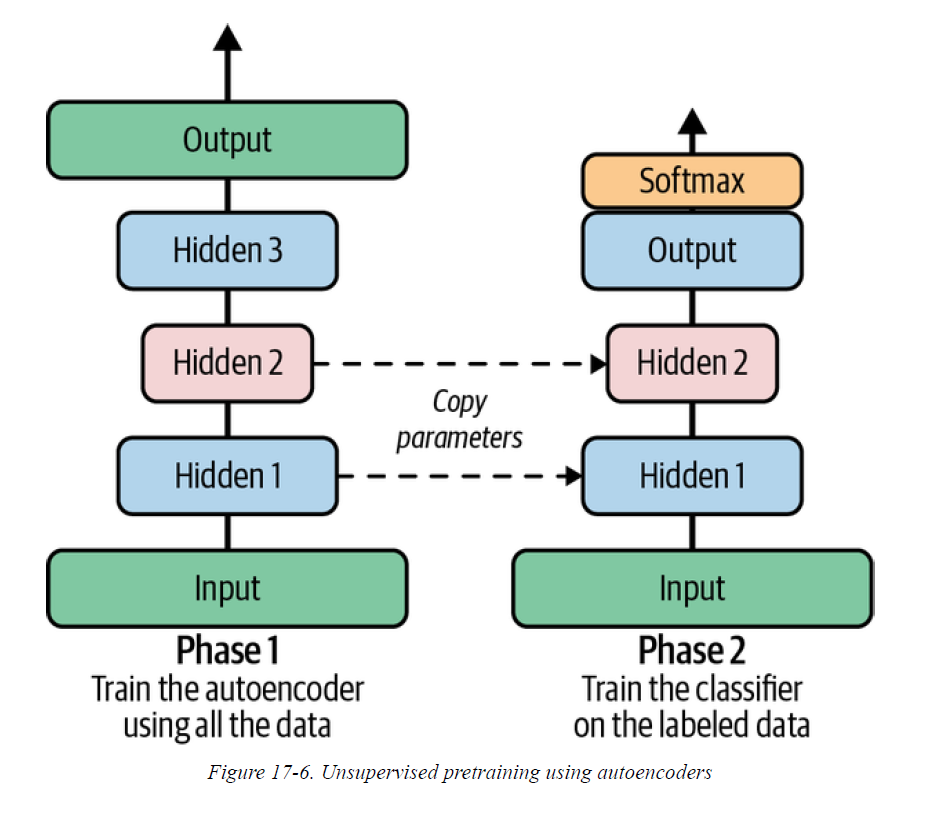

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the enocoder's weights as the decoder weights. For this, we need to use a custom layer.

In [25]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [27]:
tf.random.set_seed(42)

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0242 - val_loss: 0.0177
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0136 - val_loss: 0.0139
Epoch 10/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.01

1/1 [==============================] - 0s 56ms/step


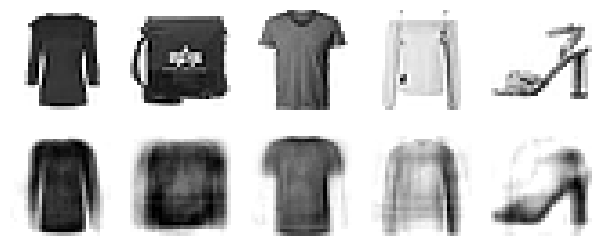

In [28]:
plot_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

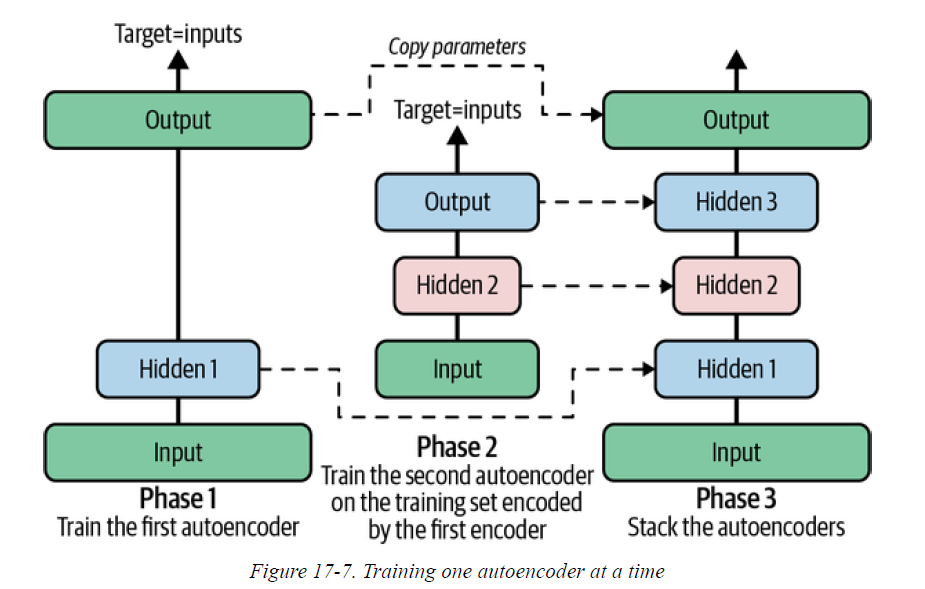

In [33]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                       output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [34]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0202 - val_loss: 0.0142
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0092 - val_loss: 0.0107
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.009

In [35]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 78ms/step


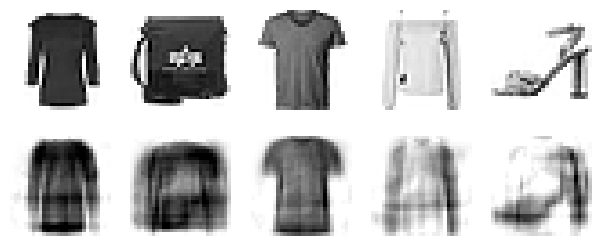

In [36]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [37]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0130 - val_loss: 0.0130


1/1 [==============================] - 0s 74ms/step


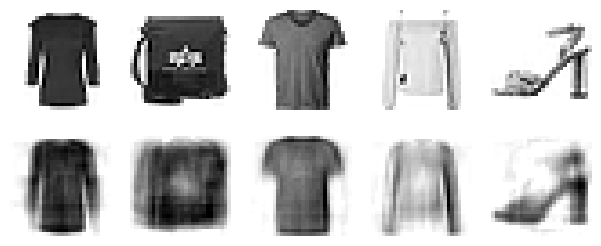

In [38]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

In [39]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (14, 14, 16)
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (7, 7, 32)
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (3, 3, 64)
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 32s 13ms/step - loss: 0.0324 - val_loss: 0.0224
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.0204 - val_loss: 0.0206
Epoch 3/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 5/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 9/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 10/10
1719/1719 [==============================] - 17s 10m

# Recurrent Autoencoders

In [13]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [14]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 44s 19ms/step - loss: 0.0289 - val_loss: 0.0205
Epoch 2/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 3/10
1719/1719 [==============================] - 30s 18ms/step - loss: 0.0160 - val_loss: 0.0163
Epoch 4/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 5/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 6/10
1719/1719 [==============================] - 30s 18ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 7/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 8/10
1719/1719 [==============================] - 28s 17ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 9/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 10/10
1719/1719 [==============================] - 37s 21m

1/1 [==============================] - 1s 961ms/step


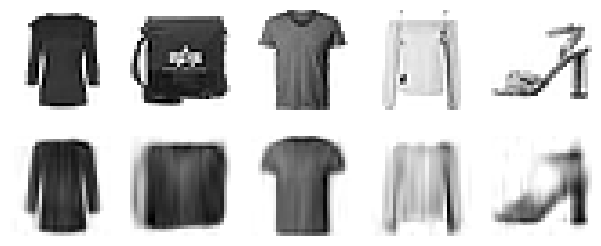

In [15]:
plot_reconstructions(recurrent_ae)
plt.show()

# Denoising Autoencoders

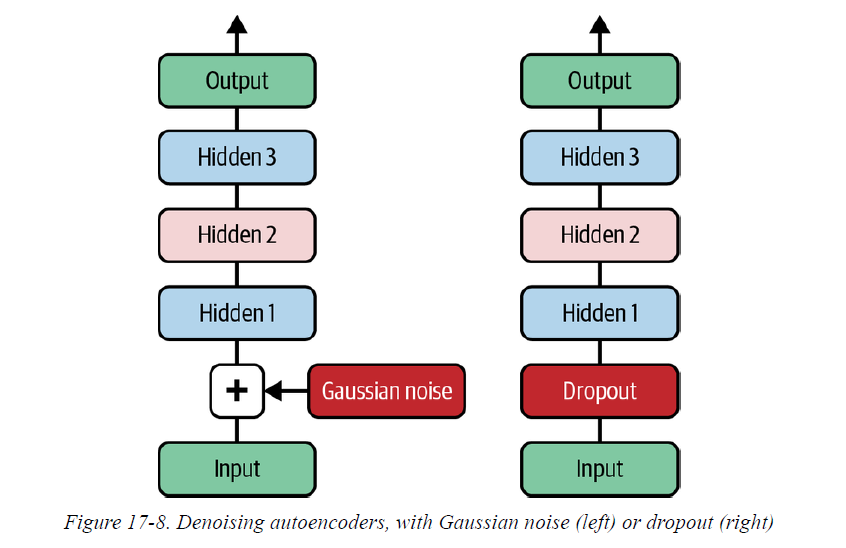

In [16]:
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.0308 - val_loss: 0.0235
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0236 - val_loss: 0.0214
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0220 - val_loss: 0.0203
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0204 - val_loss: 0.0188
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0199 - val_loss: 0.0185
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0195 - val_loss: 0.0182
Epoch 8/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 9/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 10/10
1719/1719 [==============================] - 11s 6ms/step - l

1/1 [==============================] - 0s 61ms/step


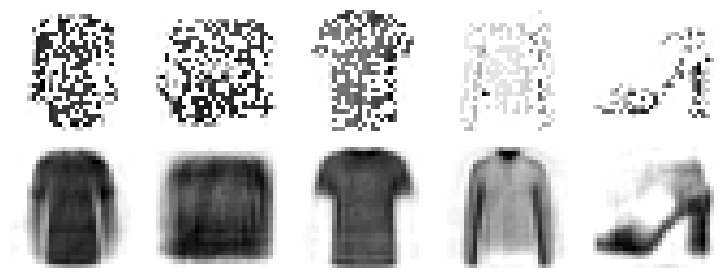

In [17]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

# Sparse Autoencoder

Let's use the sigmoid activation function in the coding layer. Let's also add $l_1$ regularization to it: to do this, we add an `ActivationRegularization` layer after the coding layer. Alternatively, we could add `activity_regularizer=tf.keras.regularizers.l1(1e-4)` to the coding layer itself.

In [12]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0292 - val_loss: 0.0206
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0184 - val_loss: 0.0169
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 10/10
1719/1719 [==============================] - 11s 6ms/step - loss:

1/1 [==============================] - 0s 72ms/step


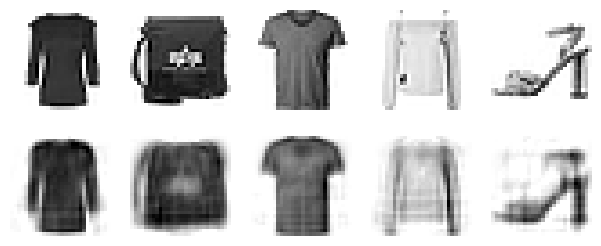

In [13]:
plot_reconstructions(sparse_l1_ae)
plt.show()

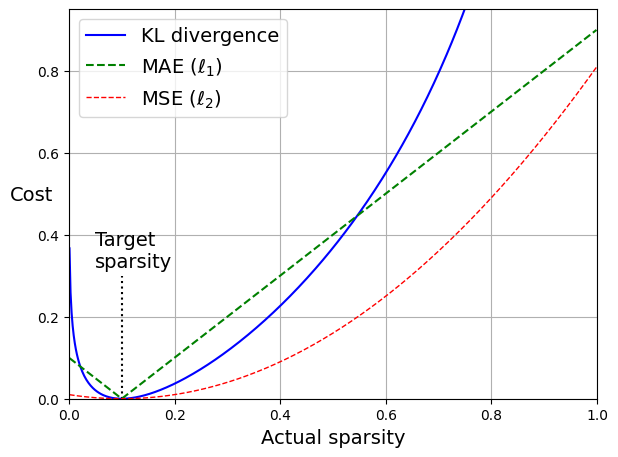

In [14]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

Custom regularizer for KL-Divergence regularization:

In [15]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [16]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 6ms/step - loss: 0.0275 - val_loss: 0.0190
Epoch 2/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 8/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 10/10
1719/1719 [==============================] - 9s 5ms/step - lo

1/1 [==============================] - 0s 90ms/step


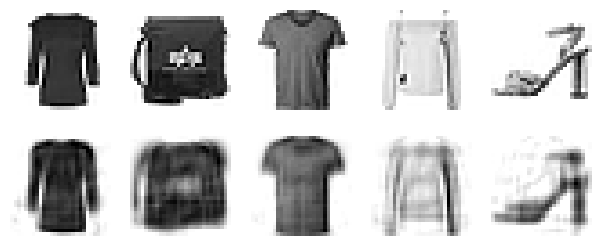

In [17]:
plot_reconstructions(sparse_kl_ae)
plt.show()

# Variational Autoencoders

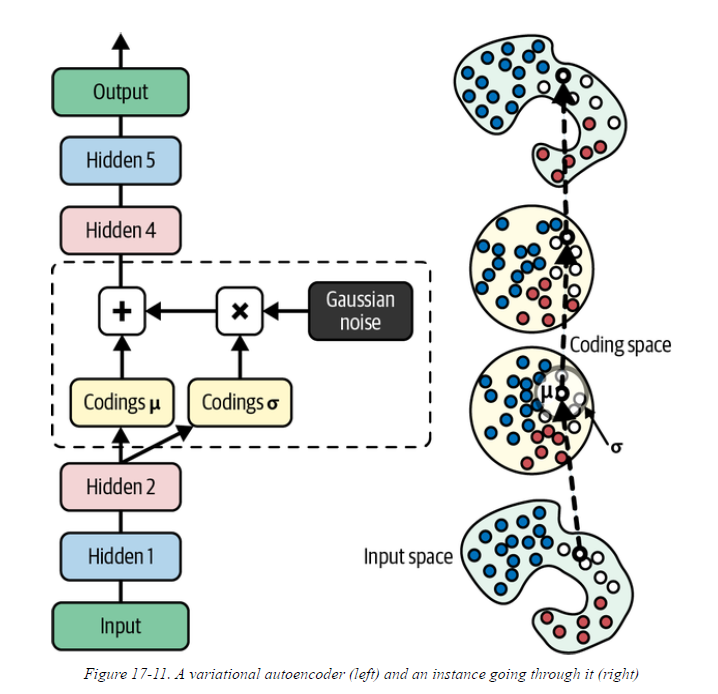

In [18]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [19]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [20]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [21]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [22]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [23]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 9ms/step - loss: 0.0518 - val_loss: 0.0400
Epoch 2/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0380 - val_loss: 0.0371
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0357 - val_loss: 0.0350
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.0345 - val_loss: 0.0340
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.0337 - val_loss: 0.0337
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 7/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0327 - val_loss: 0.0331
Epoch 8/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0325 - val_loss: 0.0327
Epoch 9/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0323 - val_loss: 0.0327
Epoch 10/25
430/430 [==============================] - 4s 9ms/step - loss: 0.0321 - val_loss: 0.0323

1/1 [==============================] - 0s 120ms/step


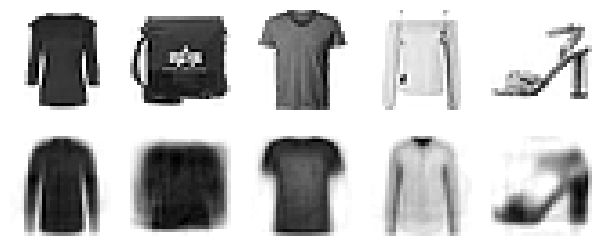

In [24]:
plot_reconstructions(variational_ae)
plt.show()

# Generate Fashion Images

In [25]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

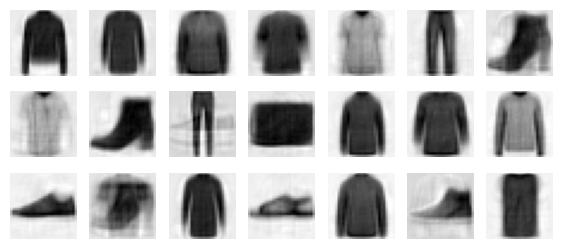

In [26]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

In [27]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()

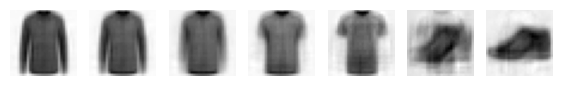

In [28]:
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()